# Wide ResNet Experiments

In this notebook we will run experiments with Wide ResNet that has increased width and decreased depth compared to the original ResNet. The model was introduced in the article https://arxiv.org/abs/1605.07146.

Recall that all the resnet architectures share the same structure. The first convolution is followed by several groups of convolutions such that convolutions in each group have the same number of filters. Authors investigated models' domain utilizing parameters k, N where k is a width multiplicative factor that enlarges number of filters in every group, N is a depth multiplicative factor that is equal to a number of residual blocks in every group.


![title](wide1.png)

In general case each group can have different number of convolutions but in our experiments it is better to fix it across a network.

Let's make sure that increasing network width positively influences perfomance and training time of ResNet models.
To do so we will train several networks with different width and depth factors and approximately the same number of parameters.

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICE = 1

env: CUDA_VISIBLE_DEVICE=1


In [97]:
import sys

import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from tensorflow.contrib.layers import xavier_initializer_conv2d
from collections import defaultdict
from tensorflow.contrib.layers import xavier_initializer_conv2d

sys.path.append("..//..")
from dataset.models.tf.resnet import ResNet

from dataset import DatasetIndex, Dataset, F, V, B, Pipeline
# from dataset import Batch, action, model, inbatch_parallel
from dataset.dataset.opensets import MNIST
from time_batch import TimeBatch
from plot_functions import plot_results

In this notebook we will run experiments on the MNIST dataset.

In [4]:
mnistset = MNIST(batch_class = TimeBatch)

ExtractingExtractingExtractingExtracting    C:\Users\Dari\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\Dari\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\Dari\AppData\Local\Temp\t10k-images-idx3-ubyte.gz
C:\Users\Dari\AppData\Local\Temp\train-labels-idx1-ubyte.gz




Let's fix batch size, number of iterations and a constant for image size:

In [5]:
IMAGE_SIZE = 28
BATCH_SIZE = 100
NUM_ITERS = 800

MNIST classification task is relatively simple. Therefore in order to use larger number of parameters we will noise data adding noise generated from small pieces of random mnist digits.

Define parameters for noise generation:

In [7]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 80    # number of noise fragments per image  
size = 4            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

Create template pipeline for normalization and noise generation:

In [8]:
template_ppl = (Pipeline()
               .normalize_images()
               .create_noise('mnist_noise', level, n_fragments, size, distr))

All networks will use the same parts of a config dictionary which defines inputs' format and loss type.

In [9]:
placeholders_config = {'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                         'name': 'reshaped_images'},
               'labels': {'classes' : 10,
                          'transform': 'ohe',
                          'name': 'targets'}}

default_config={'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'loss': 'ce',
                'output': {'ops': ['accuracy']}}

For convenience sake we define a function that creates train and test pipeleines and stores loss, accuracy and training time statistics in corresponding dicts.

In [10]:
def train_networks(template_ppl, default_config, widening_factors, depth_factors, test_losses,
                   pipelines_dict, time_dict, test_accs, name='0'):
    for index, wid_factor in enumerate(widening_factors):                
        config = {**default_config,
                  'body/num_blocks': [depth_factors[index]] * 3,  # define number of blocks for each
                                                                  # group with the same number of filters
                  'body/block/width_factor': wid_factor,
                  'body/filters': [16, 32, 64]}                   # number of filters in each group

        ppl = ((template_ppl << mnistset.train)
                         .add_noise()
                         .init_variable('start_time', init_on_each_run=0)
                         .init_variable('time_history', init_on_each_run=list)
                         .init_variable('loss_history', init_on_each_run=list)
                         .init_variable('acc_history', init_on_each_run=list)
                         .init_model('dynamic', ResNet, 'MyResNet', config)
                         .update_start_time()
                         .train_model('MyResNet', fetches=['loss', 'output_accuracy'], feed_dict={'images': B('images'),
                                                                             'labels': B('labels')},
                                     save_to=[V('loss_history'), V('acc_history')], mode='a')
                         .update_time_history())

        ppl_test = ((template_ppl << mnistset.test)
                        .add_noise()
                        .init_variable('start_time', init_on_each_run=0)
                        .init_variable('time_history', init_on_each_run=list)
                        .init_variable('loss_history', init_on_each_run=list)
                        .init_variable('acc_history', init_on_each_run=list)
                        .import_model('MyResNet', ppl)
                        .update_start_time()
                        .predict_model('MyResNet', fetches=['loss', 'output_accuracy'], feed_dict={'images': B('images'),
                                                                              'labels': B('labels')},
                                       save_to=[V('loss_history'), V('acc_history')], mode='a')
                        .update_time_history())
        
        for i in tqdm(range(NUM_ITERS)):
            ppl.next_batch(100, n_epochs=None, shuffle=True)
            ppl_test.next_batch(100, n_epochs=None, shuffle=True)

        time_dict[name + '+' + str(wid_factor)] = ppl.get_variable('time_history')
        test_losses[name + '+' + str(wid_factor)] = ppl_test.get_variable('loss_history')
        pipelines_dict[name + '+' + str(wid_factor)]  = ppl
        test_accs[name + '+' + str(wid_factor)] = ppl.get_variable('acc_history')

Create dictionaries where statistics and pipelines will be saved:

In [34]:
test_losses = defaultdict(list)
test_accs = defaultdict(list)
time_dict = defaultdict(list)
pipelines_dict = defaultdict(list)

Let's define widening and depth factors. To explore the effects of width's increasing we take multiple values in a range from 1 to 8.

Depth factors were chosen in consideration of the requirement for compared networks to have an approximately the same number of parameters in every network. To do so we could vary number of blocks for each block type. But it is more important to have the same proportion of convolutions in every group. For example for width_factor=1 and small number of convolutions in the first two groups and the bulk of convolutions in the last group we would get approximately the same result as if we took width_factor=4 with the bulk of convolutions in the first groups.

Therefore we utilize slightly more different number of parameters but fixed depth factor N across the network.

In [13]:
widening_factors = [8, 4, 3, 2, 1]
depth_factors = [1, 3, 5, 12, 44]

In [ ]:
train_networks(template_ppl, default_config, widening_factors, depth_factors, test_losses, 
               pipelines_dict, time_dict, test_accs, name='0')

Let's count number of parameters in the networks to make sure we created networks with approximately the same number of parameters:

In [104]:
all_parameters_count(pipelines_dict)

key=  0+8 n_parameters=  4831626
key=  0+4 n_parameters=  4331530
key=  0+3 n_parameters=  4195898
key=  0+2 n_parameters=  4595178
key=  0+1 n_parameters=  4278906


To compare networks perfomance let's visualize loss decay in training time.

The second graphic shows first 50 iterations.

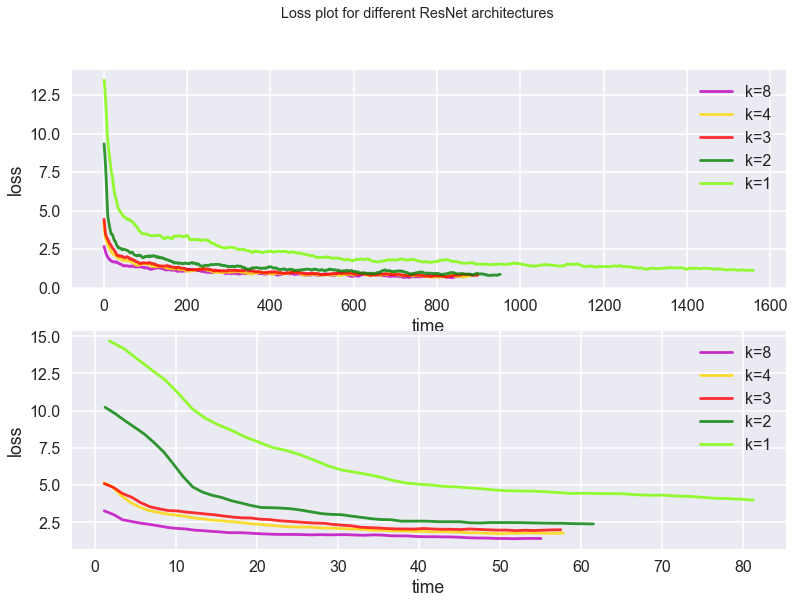

In [106]:
plot_results(['0+8', '0+4', '0+3', '0+2', '0+1'], test_losses, time_dict, 10, 50)

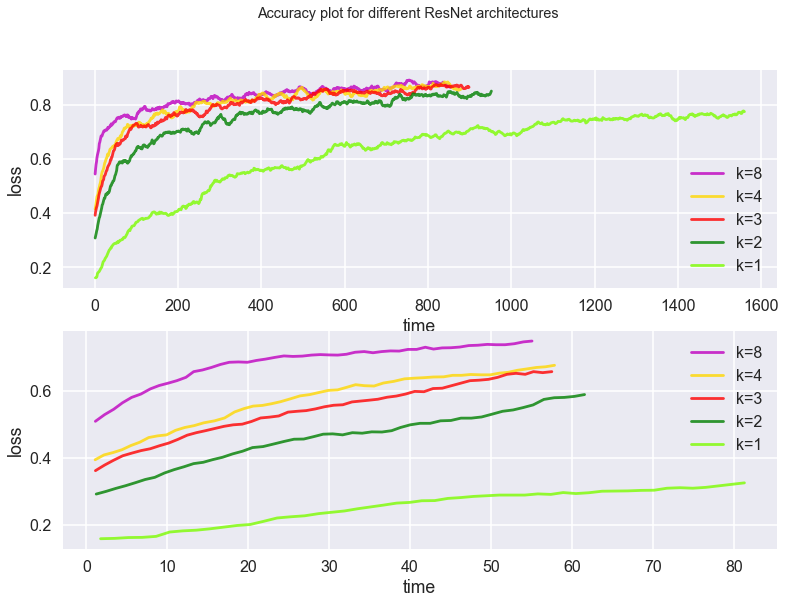

In [114]:
plot_results(['0+8', '0+4', '0+3', '0+2', '0+1'], test_accs, time_dict, 10, 50, 'Accuracy')

It seems that all the considered models are able to hit the same accuracy level sooner ar later but the wider networks do it much faster.

As the training time is essential factor in estimation perfomance of neural networks we can confirm the benefits of Wide Residual Networks.

